In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CrimeClassify').getOrCreate()

## Reading and Exploring training data

In [2]:
train = spark.read.csv('/home/jovyan/Advanced Big data project/train.csv',inferSchema=True,
                     header=True)

In [3]:
train.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [4]:
train.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

In [5]:
train.count() #there are 878049 row

878049

In [6]:
train.describe().show()

+-------+-----------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|summary|   Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------+-----------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|  count|     878049|              878049|   878049|    878049|        878049|              878049|             878049|            878049|
|   mean|       null|                null|     null|      null|          null|                null| -122.4226164550638| 37.77102029800635|
| stddev|       null|                null|     null|      null|          null|                null|0.03035362299848847|0.4568931047058097|
|    min|      ARSON|ABANDONMENT OF CHILD|   Friday|   BAYVIEW|ARREST, BOOKED|0 Block of  HARRI...|   -122.51364206429|  37.7078790224135|
|    max|WEAPON LAWS|      

#### Getting Number of Crimes per each crime category

In [7]:
#First we will get number of crimes categories
from pyspark.sql.functions import desc,col
train.groupBy(train['Category']).count().orderBy(desc("count")).count()

39

In [8]:
#Now let's get Number of crimes per District but we will take into consideration just the top 10 categories
from pyspark.sql.functions import desc,col
Crimes_Category=train.groupBy(train['Category']).count().orderBy(desc("count")).limit(10).toPandas()

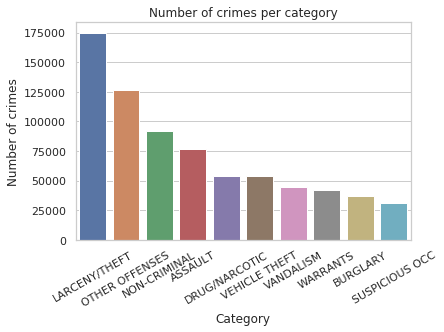

In [59]:
#Plotting a bar plot that shows number of crimes per cateogry including only the top 10 categories
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
sns.set(style="whitegrid")
sns.barplot(x="Category", y="count", data=Crimes_Category)
plt.title('Number of crimes per category')
plt.xlabel('Category')
plt.xticks(rotation=30)
plt.ylabel('Number of crimes')
plt.show()

Larceny and thefts are the most common crimes

#### Getting Number of Crimes per district

In [10]:
#getting Number of crimes per District

Crimes_District=train.groupBy(train['PdDistrict']).count().orderBy(desc("count")).toPandas()

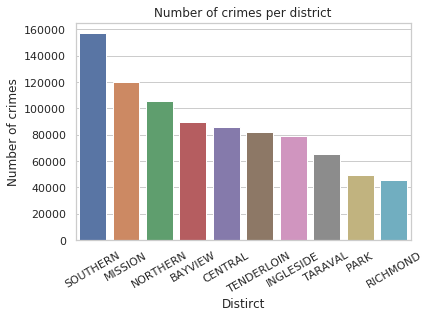

In [11]:
#Plotting a bar plot that shows number of crimes per district

plt.clf()
sns.set(style="whitegrid")
sns.barplot(x="PdDistrict", y="count", data=Crimes_District)
plt.title('Number of crimes per district')
plt.xlabel('Distirct')
plt.xticks(rotation=30)
plt.ylabel('Number of crimes')
plt.show()

Southern District suffers from the highest number of crimes while Richmond seems to be the safest place

#### Adding Year, Month and hour columns

In [12]:
#Now we will extract year, Month and hour from Dates column
from pyspark.sql.functions import hour, month, year

train=train.withColumn("Hour",hour(train.Dates)).withColumn("Month",month(train.Dates)).withColumn("Year",year(train.Dates))

In [13]:
train.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+----+-----+----+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|Hour|Month|Year|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+----+-----+----+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.80041432198

#### Getting number of crimes per year

In [14]:
#Now let's get Number of crimes per year
Crimes_year=train.groupBy(train['Year']).count().orderBy(desc("count")).toPandas()

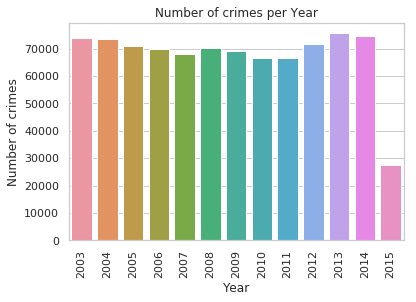

In [15]:
#Plotting a bar plot that shows number of crimes per year
plt.clf()
sns.set(style="whitegrid")
sns.barplot(x="Year", y="count", data=Crimes_year)
plt.title('Number of crimes per Year')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Number of crimes')
plt.show()

Based on the above graph there is signifcant decrease in crime in 2015 but is that really the case? Ain't is possible that the data collected didn't cover the whole year for example. let's find out

In [16]:
#We need to know whether the whole year 2015 data is available or not
train.where("Year == 2015").groupBy("Month").count().show()

+-----+-----+
|Month|count|
+-----+-----+
|    1| 5866|
|    3| 6851|
|    5| 2250|
|    4| 6609|
|    2| 6008|
+-----+-----+



Only the first 5 months of 2015 were provided but maybe this is the same for the whole data or in other words data provided is for the first 5 months only in each year so we need to check this point also

In [17]:
#Checking whether year 2014 data is for whole year or just the first 5 months
train.where("Year == 2014").groupBy("Month").count().show()

+-----+-----+
|Month|count|
+-----+-----+
|   12| 5391|
|    1| 5780|
|    6| 5992|
|    3| 6240|
|    5| 6759|
|    9| 6667|
|    4| 6549|
|    8| 6147|
|    7| 5808|
|   10| 7303|
|   11| 6471|
|    2| 5659|
+-----+-----+



Year 2014 data covers all months so significant decrease in crimes in 2015 is because the data provided for 2015 covers only the first 5 months. In order to check whether crime in 2015 or not we can check the first 5 months in each year and plot number of crimes again

In [18]:
#First of all we will filter the first 5 months only
trainFive=train.where("Month<=5")

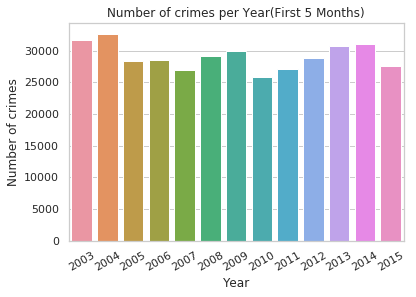

In [19]:
#Now we will plot the number of crimes for the first 5 months of each year
Crimes_5months=trainFive.groupBy(trainFive['Year']).count().orderBy(desc("count")).toPandas()

plt.clf()
sns.set(style="whitegrid")
sns.barplot(x="Year", y="count", data=Crimes_5months)
plt.title('Number of crimes per Year(First 5 Months)')
plt.xlabel('Year')
plt.xticks(rotation=30)
plt.ylabel('Number of crimes')
plt.show()

From the above graph it seems that we were right. the overall crime trend didn't decrease in 2015

#### Getting number of crimes per Day of Week

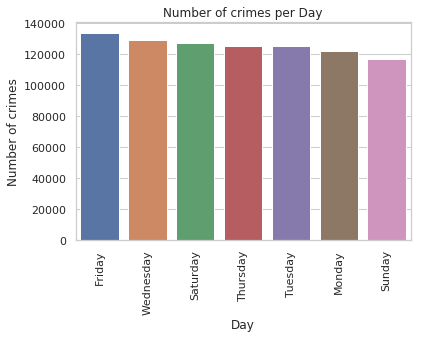

In [20]:
#Plotting Number of crimes per Day of Week
Crimes_day=train.groupBy(train['DayOfWeek']).count().orderBy(desc("count")).toPandas()

plt.clf()
sns.set(style="whitegrid")
sns.barplot(x="DayOfWeek", y="count", data=Crimes_day)
plt.title('Number of crimes per Day')
plt.xlabel('Day')
plt.xticks(rotation=90)
plt.ylabel('Number of crimes')
plt.show()

From the above graph we can say that crimes realtively increase on Fridays

### Preparing training data for classification 

In [21]:
train.printSchema()
train.columns

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



['Dates',
 'Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Hour',
 'Month',
 'Year']

In [22]:
from pyspark.sql.functions import expr
cleanedTrain=train.select('Category','DayOfWeek',expr('PdDistrict AS District'),'X','Y','Hour','Month','Year')

In [23]:
cleanedTrain.printSchema()

root
 |-- Category: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [24]:
cleanedTrain.show()

+--------------+---------+----------+-------------------+------------------+----+-----+----+
|      Category|DayOfWeek|  District|                  X|                 Y|Hour|Month|Year|
+--------------+---------+----------+-------------------+------------------+----+-----+----+
|      WARRANTS|Wednesday|  NORTHERN|  -122.425891675136|  37.7745985956747|  23|    5|2015|
|OTHER OFFENSES|Wednesday|  NORTHERN|  -122.425891675136|  37.7745985956747|  23|    5|2015|
|OTHER OFFENSES|Wednesday|  NORTHERN|   -122.42436302145|  37.8004143219856|  23|    5|2015|
| LARCENY/THEFT|Wednesday|  NORTHERN|-122.42699532676599| 37.80087263276921|  23|    5|2015|
| LARCENY/THEFT|Wednesday|      PARK|  -122.438737622757|37.771541172057795|  23|    5|2015|
| LARCENY/THEFT|Wednesday| INGLESIDE|-122.40325236121201|   37.713430704116|  23|    5|2015|
| VEHICLE THEFT|Wednesday| INGLESIDE|  -122.423326976668|  37.7251380403778|  23|    5|2015|
| VEHICLE THEFT|Wednesday|   BAYVIEW|  -122.371274317441|  37.72756407

Finally we need to change Category column from string to integer in order to input it into classifier noting that we will use CategoryIndex column during classification

In [25]:
categories=cleanedTrain.select("category").distinct().toPandas()
#categories is just a list that we will use for mapping between categories and its IDs
categories['label']=list(range(len(categories)))
categories['label']=categories['label'].astype(str)
cleanedTrain=cleanedTrain.withColumn("label",col("Category"))
cleanedTrain=cleanedTrain.replace(list(categories.category),list(categories.label),'label')
#Chanigng label column type to integer
cleanedTrain=cleanedTrain.withColumn("label",cleanedTrain['label'].cast('int'))
cleanedTrain.show()
cleanedTrain.printSchema()

+--------------+---------+----------+-------------------+------------------+----+-----+----+-----+
|      Category|DayOfWeek|  District|                  X|                 Y|Hour|Month|Year|label|
+--------------+---------+----------+-------------------+------------------+----+-----+----+-----+
|      WARRANTS|Wednesday|  NORTHERN|  -122.425891675136|  37.7745985956747|  23|    5|2015|    9|
|OTHER OFFENSES|Wednesday|  NORTHERN|  -122.425891675136|  37.7745985956747|  23|    5|2015|    7|
|OTHER OFFENSES|Wednesday|  NORTHERN|   -122.42436302145|  37.8004143219856|  23|    5|2015|    7|
| LARCENY/THEFT|Wednesday|  NORTHERN|-122.42699532676599| 37.80087263276921|  23|    5|2015|   36|
| LARCENY/THEFT|Wednesday|      PARK|  -122.438737622757|37.771541172057795|  23|    5|2015|   36|
| LARCENY/THEFT|Wednesday| INGLESIDE|-122.40325236121201|   37.713430704116|  23|    5|2015|   36|
| VEHICLE THEFT|Wednesday| INGLESIDE|  -122.423326976668|  37.7251380403778|  23|    5|2015|   33|
| VEHICLE 

### Reading and preparing testing data for classification

In [26]:
test = spark.read.csv('/home/jovyan/Advanced Big data project/test.csv',inferSchema=True,
                     header=True)

In [27]:
test.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Dates: timestamp (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [28]:
test.show()

+---+-------------------+---------+----------+--------------------+-------------------+------------------+
| Id|              Dates|DayOfWeek|PdDistrict|             Address|                  X|                 Y|
+---+-------------------+---------+----------+--------------------+-------------------+------------------+
|  0|2015-05-10 23:59:00|   Sunday|   BAYVIEW|2000 Block of THO...|-122.39958770418998|  37.7350510103906|
|  1|2015-05-10 23:51:00|   Sunday|   BAYVIEW|  3RD ST / REVERE AV|  -122.391522893042|  37.7324323864471|
|  2|2015-05-10 23:50:00|   Sunday|  NORTHERN|2000 Block of GOU...|  -122.426001954961|  37.7922124386284|
|  3|2015-05-10 23:45:00|   Sunday| INGLESIDE|4700 Block of MIS...|  -122.437393972517|  37.7214120621391|
|  4|2015-05-10 23:45:00|   Sunday| INGLESIDE|4700 Block of MIS...|  -122.437393972517|  37.7214120621391|
|  5|2015-05-10 23:40:00|   Sunday|   TARAVAL|BROAD ST / CAPITO...|-122.45902362242902|  37.7131719025215|
|  6|2015-05-10 23:30:00|   Sunday| I

In [29]:
#Adding hour, month and year columns to testing dataframe
test=test.withColumn("Hour",hour(test.Dates)).withColumn("Month",month(test.Dates)).withColumn("Year",year(test.Dates))

In [30]:
test.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Dates: timestamp (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [31]:
#Getting cleaned version of test data
cleanedTest=test.select('Id','DayOfWeek',expr('PdDistrict AS District'),'X','Y','Hour','Month','Year')

In [32]:
#This is how the testing data looks like
cleanedTest.show()

+---+---------+----------+-------------------+------------------+----+-----+----+
| Id|DayOfWeek|  District|                  X|                 Y|Hour|Month|Year|
+---+---------+----------+-------------------+------------------+----+-----+----+
|  0|   Sunday|   BAYVIEW|-122.39958770418998|  37.7350510103906|  23|    5|2015|
|  1|   Sunday|   BAYVIEW|  -122.391522893042|  37.7324323864471|  23|    5|2015|
|  2|   Sunday|  NORTHERN|  -122.426001954961|  37.7922124386284|  23|    5|2015|
|  3|   Sunday| INGLESIDE|  -122.437393972517|  37.7214120621391|  23|    5|2015|
|  4|   Sunday| INGLESIDE|  -122.437393972517|  37.7214120621391|  23|    5|2015|
|  5|   Sunday|   TARAVAL|-122.45902362242902|  37.7131719025215|  23|    5|2015|
|  6|   Sunday| INGLESIDE|-122.42561645123001| 37.73935051446279|  23|    5|2015|
|  7|   Sunday| INGLESIDE|-122.41265203979201|37.739750156312105|  23|    5|2015|
|  8|   Sunday|   MISSION|  -122.418700097043|  37.7651649409646|  23|    5|2015|
|  9|   Sunday| 

In [33]:
test.count()

884262

In [34]:
train.count()

878049

### Crimes Predictions

In [35]:
# Loading all needed libraries
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler

In this part we will change categorical data into numerical values in 2 steps first stringindexing which will output one column with number instead of categories then we will make one hot encoding which will output 1 column per category


In [36]:
district_indexer = StringIndexer(inputCol='District',outputCol='DistrictIndex')
district_encoder = OneHotEncoder(inputCol='DistrictIndex',outputCol='DistrictVec')

DayOfWeek_indexer = StringIndexer(inputCol='DayOfWeek',outputCol='DayOfWeekIndex')
DayOfWeek_encoder = OneHotEncoder(inputCol='DayOfWeekIndex',outputCol='DayOfWeekVec')

Now we will use vector assembler to put all features in one column

In [37]:
assembler = VectorAssembler(inputCols=['DayOfWeekVec',
 'DistrictVec',
 'X',
 'Y',
 'Hour',
 'Month',
 'Year'],outputCol='AssemblerFeatures')

Before classifying we will scale our features

In [38]:
feature_scaler = StandardScaler(inputCol="AssemblerFeatures",outputCol="features")

#### First we will use logistic regression as a classifier

In [39]:
log_reg_crimes = LogisticRegression(featuresCol='features',labelCol='label',regParam=0.1)

In [40]:
pipeline = Pipeline(stages=[district_indexer,DayOfWeek_indexer,
                           district_encoder,DayOfWeek_encoder,
                           assembler,feature_scaler,log_reg_crimes])

In [41]:
lr_model = pipeline.fit(cleanedTrain)

In [42]:
lr_results = lr_model.transform(cleanedTest)

In [43]:
lr_results.show(5)

+---+---------+---------+-------------------+----------------+----+-----+----+-------------+--------------+-------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
| Id|DayOfWeek| District|                  X|               Y|Hour|Month|Year|DistrictIndex|DayOfWeekIndex|  DistrictVec|DayOfWeekVec|   AssemblerFeatures|            features|       rawPrediction|         probability|prediction|
+---+---------+---------+-------------------+----------------+----+-----+----+-------------+--------------+-------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0|   Sunday|  BAYVIEW|-122.39958770418998|37.7350510103906|  23|    5|2015|          3.0|           6.0|(9,[3],[1.0])|   (6,[],[])|(20,[9,15,16,17,1...|(20,[9,15,16,17,1...|[4.33864192426199...|[0.01790737368004...|      36.0|
|  1|   Sunday|  BAYVIEW|  -122.391522893042|37.7324323864471|  23|    5|2015|  

We will create a new dataframe with only Id and probability columns

In [44]:
lr_prob=lr_results.select(col('Id'),col('probability'))
lr_prob.show(2,truncate=False)

+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |probability                                                                                                                                                           

Our target now is to change the shape of probabilities dataframe into the format accpected by kaggle and we can do it as below

In [45]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

lr_prob=lr_prob.withColumn("FRAUD",udf(lambda v:float(v[0]),FloatType())('probability'))\
.withColumn("SUICIDE",udf(lambda v:float(v[1]),FloatType())('probability'))\
.withColumn("SEX OFFENSES FORCIBLE",udf(lambda v:float(v[2]),FloatType())('probability'))\
.withColumn("LIQUOR LAWS",udf(lambda v:float(v[3]),FloatType())('probability'))\
.withColumn("SECONDARY CODES",udf(lambda v:float(v[4]),FloatType())('probability'))\
.withColumn("FAMILY OFFENSES",udf(lambda v:float(v[5]),FloatType())('probability'))\
.withColumn("MISSING PERSON",udf(lambda v:float(v[6]),FloatType())('probability'))\
.withColumn("OTHER OFFENSES",udf(lambda v:float(v[7]),FloatType())('probability'))\
.withColumn("DRIVING UNDER THE INFLUENCE",udf(lambda v:float(v[8]),FloatType())('probability'))\
.withColumn("WARRANTS",udf(lambda v:float(v[9]),FloatType())('probability'))\
.withColumn("ARSON",udf(lambda v:float(v[10]),FloatType())('probability'))\
.withColumn("SEX OFFENSES NON FORCIBLE",udf(lambda v:float(v[11]),FloatType())('probability'))\
.withColumn("FORGERY/COUNTERFEITING",udf(lambda v:float(v[12]),FloatType())('probability'))\
.withColumn("GAMBLING",udf(lambda v:float(v[13]),FloatType())('probability'))\
.withColumn("BRIBERY",udf(lambda v:float(v[14]),FloatType())('probability'))\
.withColumn("ASSAULT",udf(lambda v:float(v[15]),FloatType())('probability'))\
.withColumn("DRUNKENNESS",udf(lambda v:float(v[16]),FloatType())('probability'))\
.withColumn("EXTORTION",udf(lambda v:float(v[17]),FloatType())('probability'))\
.withColumn("TREA",udf(lambda v:float(v[18]),FloatType())('probability'))\
.withColumn("WEAPON LAWS",udf(lambda v:float(v[19]),FloatType())('probability'))\
.withColumn("LOITERING",udf(lambda v:float(v[20]),FloatType())('probability'))\
.withColumn("SUSPICIOUS OCC",udf(lambda v:float(v[21]),FloatType())('probability'))\
.withColumn("ROBBERY",udf(lambda v:float(v[22]),FloatType())('probability'))\
.withColumn("PROSTITUTION",udf(lambda v:float(v[23]),FloatType())('probability'))\
.withColumn("EMBEZZLEMENT",udf(lambda v:float(v[24]),FloatType())('probability'))\
.withColumn("BAD CHECKS",udf(lambda v:float(v[25]),FloatType())('probability'))\
.withColumn("DISORDERLY CONDUCT",udf(lambda v:float(v[26]),FloatType())('probability'))\
.withColumn("RUNAWAY",udf(lambda v:float(v[27]),FloatType())('probability'))\
.withColumn("RECOVERED VEHICLE",udf(lambda v:float(v[28]),FloatType())('probability'))\
.withColumn("VANDALISM",udf(lambda v:float(v[29]),FloatType())('probability'))\
.withColumn("DRUG/NARCOTIC",udf(lambda v:float(v[30]),FloatType())('probability'))\
.withColumn("PORNOGRAPHY/OBSCENE MAT",udf(lambda v:float(v[31]),FloatType())('probability'))\
.withColumn("TRESPASS",udf(lambda v:float(v[32]),FloatType())('probability'))\
.withColumn("VEHICLE THEFT",udf(lambda v:float(v[33]),FloatType())('probability'))\
.withColumn("NON-CRIMINAL",udf(lambda v:float(v[34]),FloatType())('probability'))\
.withColumn("STOLEN PROPERTY",udf(lambda v:float(v[35]),FloatType())('probability'))\
.withColumn("LARCENY/THEFT",udf(lambda v:float(v[36]),FloatType())('probability'))\
.withColumn("KIDNAPPING",udf(lambda v:float(v[37]),FloatType())('probability'))\
.withColumn("BURGLARY",udf(lambda v:float(v[38]),FloatType())('probability'))\
.drop('probability')\


In [46]:
lr_prob.show(3)

+---+-----------+------------+---------------------+------------+---------------+---------------+--------------+--------------+---------------------------+-----------+------------+-------------------------+----------------------+------------+------------+----------+------------+------------+-------------+-----------+------------+--------------+-----------+------------+------------+------------+------------------+------------+-----------------+-----------+-------------+-----------------------+------------+-------------+------------+---------------+-------------+------------+-----------+
| Id|      FRAUD|     SUICIDE|SEX OFFENSES FORCIBLE| LIQUOR LAWS|SECONDARY CODES|FAMILY OFFENSES|MISSING PERSON|OTHER OFFENSES|DRIVING UNDER THE INFLUENCE|   WARRANTS|       ARSON|SEX OFFENSES NON FORCIBLE|FORGERY/COUNTERFEITING|    GAMBLING|     BRIBERY|   ASSAULT| DRUNKENNESS|   EXTORTION|         TREA|WEAPON LAWS|   LOITERING|SUSPICIOUS OCC|    ROBBERY|PROSTITUTION|EMBEZZLEMENT|  BAD CHECKS|DISORDERLY

Now we will write the correctly formatted dataframe into csv using caalesce in order to get only one csv file

In [47]:
#lr_prob.coalesce(1).write.option("header", "true").csv('/home/jovyan/lr_regParam_0.1')

#### Now we will use Random Forest as a classifier


In [48]:
rf_crimes = RandomForestClassifier(featuresCol='features',labelCol='label', numTrees = 50)

In [49]:
pipeline = Pipeline(stages=[district_indexer,DayOfWeek_indexer,
                           district_encoder,DayOfWeek_encoder,
                           assembler,feature_scaler,rf_crimes])

In [50]:
rf_model = pipeline.fit(cleanedTrain)

In [51]:
rf_results = rf_model.transform(cleanedTest)

In [52]:
rf_results.show(5)

+---+---------+---------+-------------------+----------------+----+-----+----+-------------+--------------+-------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
| Id|DayOfWeek| District|                  X|               Y|Hour|Month|Year|DistrictIndex|DayOfWeekIndex|  DistrictVec|DayOfWeekVec|   AssemblerFeatures|            features|       rawPrediction|         probability|prediction|
+---+---------+---------+-------------------+----------------+----+-----+----+-------------+--------------+-------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0|   Sunday|  BAYVIEW|-122.39958770418998|37.7350510103906|  23|    5|2015|          3.0|           6.0|(9,[3],[1.0])|   (6,[],[])|(20,[9,15,16,17,1...|(20,[9,15,16,17,1...|[0.54654780229518...|[0.01093095604590...|       7.0|
|  1|   Sunday|  BAYVIEW|  -122.391522893042|37.7324323864471|  23|    5|2015|  

In [53]:
rf_prob=rf_results.select(col('Id'),col('probability'))
rf_prob=rf_prob.withColumn("FRAUD",udf(lambda v:float(v[0]),FloatType())('probability'))\
.withColumn("SUICIDE",udf(lambda v:float(v[1]),FloatType())('probability'))\
.withColumn("SEX OFFENSES FORCIBLE",udf(lambda v:float(v[2]),FloatType())('probability'))\
.withColumn("LIQUOR LAWS",udf(lambda v:float(v[3]),FloatType())('probability'))\
.withColumn("SECONDARY CODES",udf(lambda v:float(v[4]),FloatType())('probability'))\
.withColumn("FAMILY OFFENSES",udf(lambda v:float(v[5]),FloatType())('probability'))\
.withColumn("MISSING PERSON",udf(lambda v:float(v[6]),FloatType())('probability'))\
.withColumn("OTHER OFFENSES",udf(lambda v:float(v[7]),FloatType())('probability'))\
.withColumn("DRIVING UNDER THE INFLUENCE",udf(lambda v:float(v[8]),FloatType())('probability'))\
.withColumn("WARRANTS",udf(lambda v:float(v[9]),FloatType())('probability'))\
.withColumn("ARSON",udf(lambda v:float(v[10]),FloatType())('probability'))\
.withColumn("SEX OFFENSES NON FORCIBLE",udf(lambda v:float(v[11]),FloatType())('probability'))\
.withColumn("FORGERY/COUNTERFEITING",udf(lambda v:float(v[12]),FloatType())('probability'))\
.withColumn("GAMBLING",udf(lambda v:float(v[13]),FloatType())('probability'))\
.withColumn("BRIBERY",udf(lambda v:float(v[14]),FloatType())('probability'))\
.withColumn("ASSAULT",udf(lambda v:float(v[15]),FloatType())('probability'))\
.withColumn("DRUNKENNESS",udf(lambda v:float(v[16]),FloatType())('probability'))\
.withColumn("EXTORTION",udf(lambda v:float(v[17]),FloatType())('probability'))\
.withColumn("TREA",udf(lambda v:float(v[18]),FloatType())('probability'))\
.withColumn("WEAPON LAWS",udf(lambda v:float(v[19]),FloatType())('probability'))\
.withColumn("LOITERING",udf(lambda v:float(v[20]),FloatType())('probability'))\
.withColumn("SUSPICIOUS OCC",udf(lambda v:float(v[21]),FloatType())('probability'))\
.withColumn("ROBBERY",udf(lambda v:float(v[22]),FloatType())('probability'))\
.withColumn("PROSTITUTION",udf(lambda v:float(v[23]),FloatType())('probability'))\
.withColumn("EMBEZZLEMENT",udf(lambda v:float(v[24]),FloatType())('probability'))\
.withColumn("BAD CHECKS",udf(lambda v:float(v[25]),FloatType())('probability'))\
.withColumn("DISORDERLY CONDUCT",udf(lambda v:float(v[26]),FloatType())('probability'))\
.withColumn("RUNAWAY",udf(lambda v:float(v[27]),FloatType())('probability'))\
.withColumn("RECOVERED VEHICLE",udf(lambda v:float(v[28]),FloatType())('probability'))\
.withColumn("VANDALISM",udf(lambda v:float(v[29]),FloatType())('probability'))\
.withColumn("DRUG/NARCOTIC",udf(lambda v:float(v[30]),FloatType())('probability'))\
.withColumn("PORNOGRAPHY/OBSCENE MAT",udf(lambda v:float(v[31]),FloatType())('probability'))\
.withColumn("TRESPASS",udf(lambda v:float(v[32]),FloatType())('probability'))\
.withColumn("VEHICLE THEFT",udf(lambda v:float(v[33]),FloatType())('probability'))\
.withColumn("NON-CRIMINAL",udf(lambda v:float(v[34]),FloatType())('probability'))\
.withColumn("STOLEN PROPERTY",udf(lambda v:float(v[35]),FloatType())('probability'))\
.withColumn("LARCENY/THEFT",udf(lambda v:float(v[36]),FloatType())('probability'))\
.withColumn("KIDNAPPING",udf(lambda v:float(v[37]),FloatType())('probability'))\
.withColumn("BURGLARY",udf(lambda v:float(v[38]),FloatType())('probability'))\
.drop('probability')

In [54]:
#rf_prob.coalesce(1).write.option("header", "true").csv('/home/jovyan/rf_numTrees_50')

#### Finally we will try Decision Tree classifier

In [55]:
from pyspark.ml.classification import DecisionTreeClassifier

dt_crimes = DecisionTreeClassifier(featuresCol='features',labelCol='label',maxDepth=5)

In [56]:
pipeline = Pipeline(stages=[district_indexer,DayOfWeek_indexer,
                           district_encoder,DayOfWeek_encoder,
                           assembler,feature_scaler,dt_crimes])

dt_model = pipeline.fit(cleanedTrain)
dt_results = dt_model.transform(cleanedTest)
dt_results.show(5)

+---+---------+---------+-------------------+----------------+----+-----+----+-------------+--------------+-------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
| Id|DayOfWeek| District|                  X|               Y|Hour|Month|Year|DistrictIndex|DayOfWeekIndex|  DistrictVec|DayOfWeekVec|   AssemblerFeatures|            features|       rawPrediction|         probability|prediction|
+---+---------+---------+-------------------+----------------+----+-----+----+-------------+--------------+-------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0|   Sunday|  BAYVIEW|-122.39958770418998|37.7350510103906|  23|    5|2015|          3.0|           6.0|(9,[3],[1.0])|   (6,[],[])|(20,[9,15,16,17,1...|(20,[9,15,16,17,1...|[1796.0,101.0,903...|[0.01108340944434...|       7.0|
|  1|   Sunday|  BAYVIEW|  -122.391522893042|37.7324323864471|  23|    5|2015|  

In [57]:
dt_prob=dt_results.select(col('Id'),col('probability'))
dt_prob=dt_prob.withColumn("FRAUD",udf(lambda v:float(v[0]),FloatType())('probability'))\
.withColumn("SUICIDE",udf(lambda v:float(v[1]),FloatType())('probability'))\
.withColumn("SEX OFFENSES FORCIBLE",udf(lambda v:float(v[2]),FloatType())('probability'))\
.withColumn("LIQUOR LAWS",udf(lambda v:float(v[3]),FloatType())('probability'))\
.withColumn("SECONDARY CODES",udf(lambda v:float(v[4]),FloatType())('probability'))\
.withColumn("FAMILY OFFENSES",udf(lambda v:float(v[5]),FloatType())('probability'))\
.withColumn("MISSING PERSON",udf(lambda v:float(v[6]),FloatType())('probability'))\
.withColumn("OTHER OFFENSES",udf(lambda v:float(v[7]),FloatType())('probability'))\
.withColumn("DRIVING UNDER THE INFLUENCE",udf(lambda v:float(v[8]),FloatType())('probability'))\
.withColumn("WARRANTS",udf(lambda v:float(v[9]),FloatType())('probability'))\
.withColumn("ARSON",udf(lambda v:float(v[10]),FloatType())('probability'))\
.withColumn("SEX OFFENSES NON FORCIBLE",udf(lambda v:float(v[11]),FloatType())('probability'))\
.withColumn("FORGERY/COUNTERFEITING",udf(lambda v:float(v[12]),FloatType())('probability'))\
.withColumn("GAMBLING",udf(lambda v:float(v[13]),FloatType())('probability'))\
.withColumn("BRIBERY",udf(lambda v:float(v[14]),FloatType())('probability'))\
.withColumn("ASSAULT",udf(lambda v:float(v[15]),FloatType())('probability'))\
.withColumn("DRUNKENNESS",udf(lambda v:float(v[16]),FloatType())('probability'))\
.withColumn("EXTORTION",udf(lambda v:float(v[17]),FloatType())('probability'))\
.withColumn("TREA",udf(lambda v:float(v[18]),FloatType())('probability'))\
.withColumn("WEAPON LAWS",udf(lambda v:float(v[19]),FloatType())('probability'))\
.withColumn("LOITERING",udf(lambda v:float(v[20]),FloatType())('probability'))\
.withColumn("SUSPICIOUS OCC",udf(lambda v:float(v[21]),FloatType())('probability'))\
.withColumn("ROBBERY",udf(lambda v:float(v[22]),FloatType())('probability'))\
.withColumn("PROSTITUTION",udf(lambda v:float(v[23]),FloatType())('probability'))\
.withColumn("EMBEZZLEMENT",udf(lambda v:float(v[24]),FloatType())('probability'))\
.withColumn("BAD CHECKS",udf(lambda v:float(v[25]),FloatType())('probability'))\
.withColumn("DISORDERLY CONDUCT",udf(lambda v:float(v[26]),FloatType())('probability'))\
.withColumn("RUNAWAY",udf(lambda v:float(v[27]),FloatType())('probability'))\
.withColumn("RECOVERED VEHICLE",udf(lambda v:float(v[28]),FloatType())('probability'))\
.withColumn("VANDALISM",udf(lambda v:float(v[29]),FloatType())('probability'))\
.withColumn("DRUG/NARCOTIC",udf(lambda v:float(v[30]),FloatType())('probability'))\
.withColumn("PORNOGRAPHY/OBSCENE MAT",udf(lambda v:float(v[31]),FloatType())('probability'))\
.withColumn("TRESPASS",udf(lambda v:float(v[32]),FloatType())('probability'))\
.withColumn("VEHICLE THEFT",udf(lambda v:float(v[33]),FloatType())('probability'))\
.withColumn("NON-CRIMINAL",udf(lambda v:float(v[34]),FloatType())('probability'))\
.withColumn("STOLEN PROPERTY",udf(lambda v:float(v[35]),FloatType())('probability'))\
.withColumn("LARCENY/THEFT",udf(lambda v:float(v[36]),FloatType())('probability'))\
.withColumn("KIDNAPPING",udf(lambda v:float(v[37]),FloatType())('probability'))\
.withColumn("BURGLARY",udf(lambda v:float(v[38]),FloatType())('probability'))\
.drop('probability')

In [58]:
#dt_prob.coalesce(1).write.option("header", "true").csv('/home/jovyan/dt_maxDepth_5')